In [8]:
from InventoryEnv2 import MultiSKUInventoryEnvV2
from InventoryEnv2 import DQNAgent
from InventoryEnv2 import ReplayBuffer,sku_feature_vector
import torch

import matplotlib.pyplot as plt
import numpy as np

def train_dqn_with_log(n_sku=500, episodes=30, horizon=60, device='cpu'):
    """
    Huấn luyện DQN agent với logging, trả về lịch sử reward cho vẽ biểu đồ.
    """
    env = MultiSKUInventoryEnvV2(N_SKU=n_sku, lead_time=2, horizon=horizon)
    n_actions = 7
    action_buckets = np.array([0,1,2,5,10,20,50], dtype=int)
    input_dim = 10
    agent = DQNAgent(input_dim, n_actions, lr=1e-3, gamma=0.9, device=device)
    buffer = ReplayBuffer(capacity=200000)

    eps_start, eps_end = 0.5, 0.02
    eps_decay = episodes * n_sku * horizon / 20.0

    total_rewards = []
    avg_rewards = []

    for ep in range(episodes):
        state = env.reset()
        ep_reward = 0.0
        done = False
        while not done:
            M = min(256, env.N)
            skus = np.random.choice(env.N, size=M, replace=False)
            feats = np.stack([sku_feature_vector(state, s, lead_time=env.lead_time) for s in skus])

            ttotal = agent.steps
            eps = max(eps_end, eps_start - (eps_start - eps_end) * (ttotal / max(1, eps_decay)))

            with torch.no_grad():
                qvals = agent.q_values(feats).cpu().numpy()

            actions_idx = []
            for i in range(M):
                if np.random.rand() < eps:
                    actions_idx.append(np.random.randint(n_actions))
                else:
                    actions_idx.append(int(np.argmax(qvals[i])))

            orders = np.zeros(env.N, dtype=int)
            for i, s in enumerate(skus):
                base = action_buckets[actions_idx[i]]
                scale = int(max(1, round(state["mu"][s] / 5.0)))
                orders[s] = int(base * scale)

            next_state, reward_per_sku, done, info = env.step(orders)
            ep_reward += reward_per_sku.sum()

            for i, s in enumerate(skus):
                st_vec = feats[i]
                act = actions_idx[i]
                r = float(reward_per_sku[s])
                next_vec = sku_feature_vector(next_state, s, lead_time=env.lead_time)
                buffer.push(st_vec, act, r, next_vec, float(done))

            agent.update(buffer, batch_size=128, tau=0.005)
            agent.steps += 1
            state = next_state

        total_rewards.append(ep_reward)
        avg_rewards.append(np.mean(total_rewards[-5:]))  # moving average
        print(f"Episode {ep+1}/{episodes} - reward: {ep_reward:.2f}, avg(5): {avg_rewards[-1]:.2f}, eps: {eps:.3f}")

    return agent, env, total_rewards, avg_rewards




In [9]:
def plot_training_rewards(total_rewards, avg_rewards=None):
    """
    Vẽ biểu đồ reward qua episode, kèm moving average nếu có.
    """
    plt.figure(figsize=(10,5))
    plt.plot(total_rewards, label="Episode reward")
    if avg_rewards is not None:
        plt.plot(avg_rewards, label="Moving average (5 episodes)")
    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title("Learning curve - DQN Inventory Agent")
    plt.legend()
    plt.grid(True)
    plt.show()

Episode 1/500 - reward: -423139474.50, avg(5): -423139474.50, eps: 0.500
Episode 2/500 - reward: -409302574.80, avg(5): -416221024.65, eps: 0.500
Episode 3/500 - reward: -435137293.33, avg(5): -422526447.54, eps: 0.500
Episode 4/500 - reward: -443665383.29, avg(5): -427811181.48, eps: 0.500
Episode 5/500 - reward: -432961836.01, avg(5): -428841312.39, eps: 0.500
Episode 6/500 - reward: -421695784.45, avg(5): -428552574.38, eps: 0.500
Episode 7/500 - reward: -434050859.20, avg(5): -433502231.26, eps: 0.500
Episode 8/500 - reward: -438417018.75, avg(5): -434158176.34, eps: 0.500
Episode 9/500 - reward: -439470591.42, avg(5): -433319217.97, eps: 0.500
Episode 10/500 - reward: -402515715.53, avg(5): -427229993.87, eps: 0.500
Episode 11/500 - reward: -420755485.38, avg(5): -427041934.06, eps: 0.500
Episode 12/500 - reward: -415087957.41, avg(5): -423249353.70, eps: 0.500
Episode 13/500 - reward: -413756012.86, avg(5): -418317152.52, eps: 0.500
Episode 14/500 - reward: -390252526.47, avg(5):

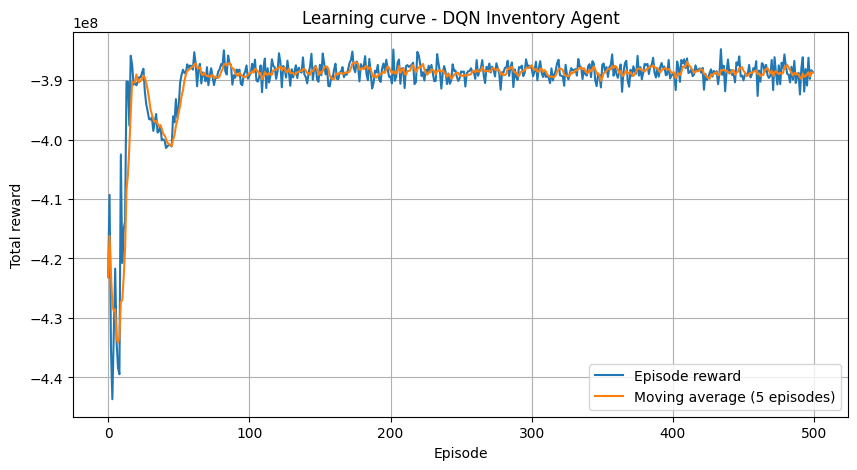

In [12]:
# chạy training
agent, env, rewards, avg_rewards = train_dqn_with_log(n_sku=10000, episodes=500, horizon=60, device="cpu")

# vẽ biểu đồ hội tụ
plot_training_rewards(rewards, avg_rewards)